## Create labels for all images

In [36]:
import os
# import shutil
import pandas as pd
import math
import numpy as np
from PIL import Image
classes = ["Alzheimer", "MCI", "Normal"]
sourceDir = '/home/nagdev/work/siddhant/data/raw/'
count = 0
for class_ in classes:
    print class_
    for root,dir,files in os.walk(os.path.join(sourceDir,class_)):
        print os.path.join(sourceDir,class_)
        with open('/home/nagdev/work/siddhant/data/raw/all.csv','a') as o:
            for f in files:
                o.write(f + ',' + str(count) +'\n')
    count += 1
    print count


Alzheimer
/home/nagdev/work/siddhant/data/raw/Alzheimer
1
MCI
/home/nagdev/work/siddhant/data/raw/MCI
2
Normal
/home/nagdev/work/siddhant/data/raw/Normal
3


## Create tefla Ready Data

In [39]:
import os
# import shutil
import pandas as pd
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
# script to create a tefla compatible data dir for training and validation data
sourceDir = '/home/nagdev/work/siddhant/data/raw/'
destDir = '/home/nagdev/work/siddhant/data/raw/processed/'
categories_picked_for_validation_data = [0,1,2]
categories_picked_for_test_data = [0,1,2]
validation_data_percentage = 10
test_data_percentage = 20

def create_tefla_data(source_dir,destination_dir,validation_categories,test_categories,validation_percentage,test_percentage):
    #if os.path.exists(destination_dir):
    #    shutil.rmtree(destination_dir)

    training_dir = destination_dir + 'training_224/'
    validation_dir = destination_dir + 'validation_224/'
    test_dir = destination_dir + 'test_224/'
    os.makedirs(training_dir)
    os.makedirs(validation_dir)
    os.makedirs(test_dir)

    labels = pd.read_csv( source_dir + 'all.csv')
    print labels.head()
    validation_dict = {}
    test_dict = {}

    for c in validation_categories:
        validation_dict[c] = []

    for c in test_categories:
        test_dict[c] = []


    # test set creation
    test_set = []

    for i, rows in labels.iterrows():
        if test_dict.has_key(rows['label']):
            test_dict[rows['label']].append(rows['image'])

    for k in test_dict:
        np.random.seed(0)
        n = math.ceil(test_percentage * len(test_dict[k]) / 100.0)
        random_array = np.random.choice(test_dict[k],int(n))
        test_set = test_set + random_array.tolist()


    #validation set creation
    validation_set = []

    for i, rows in labels.iterrows():
        if rows['image'] not in test_set:
            if validation_dict.has_key(rows['label']):
                validation_dict[rows['label']].append(rows['image'])

    for l in validation_dict:
        np.random.seed(0)
        n = math.ceil(validation_percentage * len(validation_dict[l]) / 100.0)
        random_array = np.random.choice(validation_dict[l],int(n))
        validation_set = validation_set + random_array.tolist()

    training_images = []
    training_labels = []
    validation_images = []
    validation_labels =[]
    test_images = []
    test_labels = []

    for i, rows in labels.iterrows():
        new_name = rows['image']
        new_label = rows['label']

        if rows['image'] in test_set:
            test_images.append(new_name)
            test_labels.append(new_label)
            process_and_save_image(sourceDir + 'data/' + rows['image'] + ".jpg", test_dir + new_name + ".tiff");
        elif rows['image'] in validation_set:
            validation_images.append(new_name)
            validation_labels.append(new_label)
            process_and_save_image(sourceDir + 'data/' + rows['image'] + ".jpg", validation_dir + new_name + ".tiff")
        else:
            training_images.append(new_name)
            training_labels.append(new_label)
            process_and_save_image(sourceDir + 'data/' + rows['image'] + ".jpg", training_dir + new_name + ".tiff")

    header = ['image', 'label']

    # saving training csv
    training_out = np.column_stack((training_images, training_labels))
    training_out = np.row_stack((header, training_out))
    np.savetxt(destination_dir + 'training_labels.csv', training_out, delimiter=',', fmt='%s')

    # saving validation csv
    validation_out = np.column_stack((validation_images, validation_labels))
    validation_out = np.row_stack((header, validation_out))
    np.savetxt(destination_dir + 'validation_labels.csv', validation_out, delimiter=',', fmt='%s')

    # saving testing csv
    test_out = np.column_stack((test_images, test_labels))
    test_out = np.row_stack((header, test_out))
    np.savetxt(destination_dir + 'test_labels.csv', test_out, delimiter=',', fmt='%s')

def process_and_save_image(source_path,destination_path):
    img = resize(source_path, 224)
    img.save(destination_path, quality=100)

def resize(fname, target_size):
    # print('Processing image: %s' % fname)
    img = Image.open(fname)
    return img

#calling method
create_tefla_data(sourceDir,destDir,categories_picked_for_validation_data,categories_picked_for_test_data,validation_data_percentage,test_data_percentage)



             image  label
0   Alzheimer61_12      0
1    Alzheimer5_42      0
2    Alzheimer72_1      0
3   Alzheimer17_11      0
4  Alzheimer129_39      0


In [51]:
img = Image.open('/home/nagdev/work/siddhant/data/raw/processed/training_224/Alzheimer0_0.tiff')

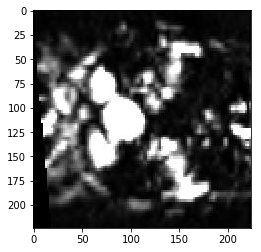

In [52]:
plt.imshow(img)
plt.show()

In [27]:
import matplotlib.pyplot as plt

In [40]:
np.asarray(img).shape

(224, 224, 3)